In [1]:
import time
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

Peržiūrėjus aukcionų duomenis,pastebėta, kad tam tikros rūšys parduodamos už žymiai didesnes nei vidutinės rinkos kainas, kas gali iškraipyti bendrą prognozės rezultatą. Kad užtikrinti tikslius ir patikimus duomenis, nuspręsta pašalinti šias rūšis, kad jie neturėtų įtakos vėlesnėms analizėms ir modelių treniravimui.

In [2]:
df = pd.read_excel(r"C:\Mokymu_medziaga\Mano projektas\My_project\df_aukcionai_2020_2021_2022_new.xlsx")
df = df[~df["Rušies pavadinimas"].isin(["Ąžuolas", "Uosis", "Skroblas", "Liepa"])]
df.head()

,Sutarties nr.,Pardavėjas,Pirkėjas,Trukmė,Sortimento pavadinimas,Rušies pavadinimas,Kokybės klasė,Stambumo klasė,"Ilgio klase,m","Kaina aukcione, Eur","Sandorio kiekis, m3",Aukciono metai
0,512100000157-P,VĮ Anykščių miškų urėdija,"""Aukštaitijos mediena"", D. Arlausko IĮ",Pusmetinė,Pjautinieji rąstai,Drebulė,B/C,Vd 20-31,L3: 4.0-6.0,105.00,40,2022
1,512000000213-I,VĮ Anykščių miškų urėdija,"""Aukštaitijos mediena"", D. Arlausko IĮ",Ilgalaikė,Plokščių mediena,Lapuočiai,E,Sm 19,L1: 2.4-3.0,14.66,2500,2022
2,512000000213-I,VĮ Anykščių miškų urėdija,"""Aukštaitijos mediena"", D. Arlausko IĮ",Ilgalaikė,Plokščių mediena,Lapuočiai,E,Sm 19,L1: 2.4-3.0,14.66,2500,2022
3,512000000213-I,VĮ Anykščių miškų urėdija,"""Aukštaitijos mediena"", D. Arlausko IĮ",Ilgalaikė,Plokščių mediena,Lapuočiai,E,Sm 19,L1: 2.4-3.0,14.66,2500,2022
4,512000000233-P,VĮ Anykščių miškų urėdija,"""Aukštaitijos mediena"", D. Arlausko IĮ",Pusmetinė,Plokščių mediena,Lapuočiai,E,Sm 19,L2: 3.0-3.9,15.20,200,2021


In [3]:
df["Rušies pavadinimas"].unique()

array(['Drebulė', 'Lapuočiai', 'Juodalksnis', 'Beržas', 'Spygliuočiai',
       'Eglė', 'Pušis', 'Minkštieji lapuočiai'], dtype=object)

Nurodoma, kurie stulpeliai turi būti laikomi kategoriniais. 

Pasirenkami nepriklausomi kintamieji (X) ir priklausomas kintamasis (Y), t.y., tikslas, kurį bandysime prognozuoti.

In [4]:
categorical_cols = ["Pardavėjas", "Pirkėjas", "Sortimento pavadinimas", "Rušies pavadinimas", 
                    "Kokybės klasė", "Stambumo klasė", "Ilgio klase,m"]

# df[categorical_cols] = df2020_2021_2023_clean_oak[categorical_cols].apply(lambda col: col.str.upper())
X = df[categorical_cols]
Y = df["Kaina aukcione, Eur"]

Duomenų padalijimas į treniravimo ir testavimo rinkinius

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Pasirenkas modeliu sarasas įvertinimui

In [6]:
models = [
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("XGBoost", xgb.XGBRegressor(random_state=42)),
    ("Lasso", Lasso(alpha=0.1))
]

Kategorinių stulpelių apdorojimas (One-Hot Encoding), atliekamas kategorinių kintamųjų kodavimas

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ]
)

Modelių treniravimas ir vertinimas

In [8]:
results = []

for model_name, model in models:
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    start_time = time.time()
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append((model_name, mae, mse, rmse, r2, training_time))

In [29]:
results_df = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "RMSE", "R2", "Training Time (s)"])
# pd.options.display.float_format ='{:,.3f}'.format
results_df

,Model,MAE,MSE,RMSE,R2,Training Time (s)
0,Random Forest,1.675997,16.260039,4.032374,0.957444,341.483324
1,XGBoost,3.498341,25.673118,5.066865,0.932809,3.162105
2,Lasso,6.381869,71.924979,8.480860,0.811759,22.070987


*RMSE (Root Mean Squared Error):  Vidutinė klaida, kuri parodo, kiek vidutiniškai modelis klysta prognozuodamas. Mažesnė šio skaičiaus reikšmė rodo, kad modelis tiksliau prognozuoja.*

*R² (R-squared): Kiek modelis sugeba paaiškinti tikrųjų reikšmių svyravimus. Vertė turi būti kuo arčiau 1, kad modelis būtų geras.
(pvz 0.81 – tai rodo, kad modelis paaiškina apie 81% tikslinės reikšmės)*

*MAE (Mean Absolute Error) – vidutinė absoliuti klaida.
MAE rodo, kiek vidutiniškai klaidingos yra prognozės.Maža MAE reikšmė rodo, kad prognozės yra tikslios.*

*MSE padidina didelių klaidų poveikį, nes klaidos kvadratuojamos. Tai reiškia, kad didelės klaidos turės daug didesnį poveikį MSE nei mažos klaidos.*

#### Geriausio modelio pasirinkimas ir issaugojimas

In [30]:
best_model_name = "XGBoost"
best_model = xgb.XGBRegressor(random_state=42)

In [32]:
best_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb.XGBRegressor(random_state=42))
])

In [33]:
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Pardavėjas', 'Pirkėjas',
                                                   'Sortimento pavadinimas',
                                                   'Rušies pavadinimas',
                                                   'Kokybės klasė',
                                                   'Stambumo klasė',
                                                   'Ilgio klase,m'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_b...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [34]:
FILES_PATH = Path(r"C:\Mokymu_medziaga\Mano projektas\My_project\models")
joblib.dump(best_pipeline, FILES_PATH / "best_xgboost_model1.pkl")

['C:\\Mokymu_medziaga\\Mano projektas\\My_project\\models\\best_xgboost_model1.pkl']

Pateikiama pagrindinė informacija apie modelio prognozės rezultatus, palyginant tikrąsias vertes su prognozuotomis ir apskaičiuojant prognozės klaidas

In [36]:
results_pred = pd.DataFrame({"True Values": y_test, "Predicted Values": y_pred, "Errors": y_test - y_pred})
results_pred.head()

,True Values,Predicted Values,Errors
14814,53.25,61.086068,-7.836068
92799,79.17,73.858448,5.311552
105093,54.45,57.372050,-2.922050
130,43.74,52.752811,-9.012811
84310,66.09,68.237359,-2.147359


Vizualizacija -  modelio prognozuotų kainų palyginimas su faktinėmis (tikrosiomis) kainomis

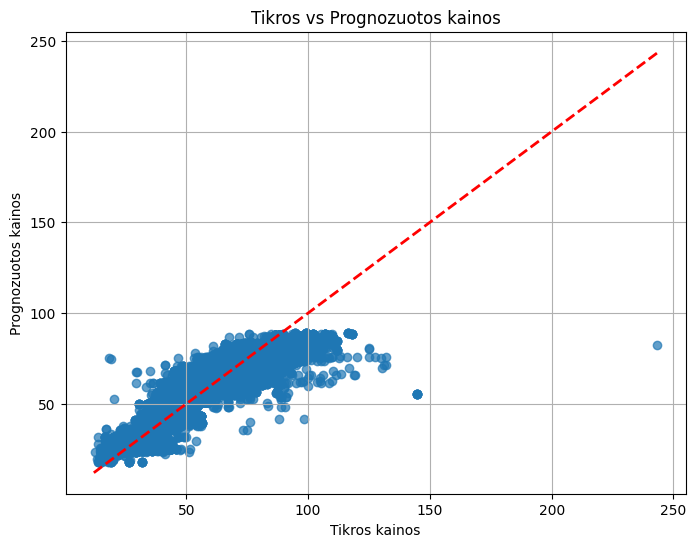

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Tikros kainos")
plt.ylabel("Prognozuotos kainos")
plt.title("Tikros vs Prognozuotos kainos")
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color="red", lw=2, linestyle="--")
plt.grid(visible=True)  # Pakeista iš plt.grid(True)
plt.show()

In [38]:
best_pipeline = joblib.load(FILES_PATH / "best_xgboost_model1.pkl")
best_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Pardavėjas', 'Pirkėjas',
                                                   'Sortimento pavadinimas',
                                                   'Rušies pavadinimas',
                                                   'Kokybės klasė',
                                                   'Stambumo klasė',
                                                   'Ilgio klase,m'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_b...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [39]:
df.head(1)

,Sutarties nr.,Pardavėjas,Pirkėjas,Trukmė,Sortimento pavadinimas,Rušies pavadinimas,Kokybės klasė,Stambumo klasė,"Ilgio klase,m","Kaina aukcione, Eur","Sandorio kiekis, m3",Aukciono metai
0,512100000157-P,VĮ Anykščių miškų urėdija,"""Aukštaitijos mediena"", D. Arlausko IĮ",Pusmetinė,Pjautinieji rąstai,Drebulė,B/C,Vd 20-31,L3: 4.0-6.0,105.0,40,2022


Įkeliama kita Excel lentelė su 2023 metų aukcioų rezultatais, kuri bus naudojama prognozavimui su išsaugotu modeliu. Suvienodinami stulpelių pavadinimai, kurie skiriasi nuo tų, kurie buvo naudojami modelio treniravimui. Išimamos rūšys, kurios buvo išimtos treniravimosi metu iš pirmos lentelės.

In [40]:
df2023 = pd.read_excel(r"C:\Mokymu_medziaga\Mano projektas\My_project\2023_aukcionu_rezultatai.xlsx")

df2023 = df2023.rename(columns={
    "Pardavėjo pavadinimas": "Pardavėjas",
    "Pirkėjo pavadinimas": "Pirkėjas",
    "Sortimentas": "Sortimento pavadinimas",
    "Rūšis": "Rušies pavadinimas",
    "Ilgio klasė": "Ilgio klase,m",
    "Sandorio kiekis": "Sandorio kiekis, m3",
    "Pirkimo kaina": "Kaina aukcione, Eur"

})
# Ištrinti eiles, kuriose "Rušies pavadinimas" yra "Ąžuolas" arba "Uosis"
df2023_cleaned = df2023[~df2023["Rušies pavadinimas"].isin(["Ąžuolas", "Uosis", "Skroblas", "Liepa"])]

df2023_cleaned.head()

,Aukciono tipas,Aukciono pavadinimas,Pardavėjas,Sortimento pavadinimas,Rušies pavadinimas,Kokybės klasė,Stambumo klasė,"Ilgio klase,m",Pardavimo kiekis,Pardavimo kaina,Pardavimo pasiūlymo ID,Pirkėjas,Pirkimo kiekis,"Kaina aukcione, Eur","Sandorio kiekis, m3"
0,ILGALAIKIS,I pusmetis,Anykščių regioninis padalinys,Pjautinieji rąstai,Pušis,B/C,VD 20-31,L3: 4.0-6.0,1000,111.5,304104444,"""Aukštaitijos mediena"", D. Arlausko IĮ",400,96.59,0
1,ILGALAIKIS,I pusmetis,Ignalinos regioninis padalinys,Pjautinieji rąstai,Pušis,B/C,VD 20-31,L3: 4.0-6.0,1000,98.0,304104444,"""Aukštaitijos mediena"", D. Arlausko IĮ",600,85.59,0
2,ILGALAIKIS,I pusmetis,Jurbarko regioninis padalinys,Pjautinieji rąstai,Pušis,B/C,VD 20-31,L3: 4.0-6.0,720,107.0,304104444,"""Aukštaitijos mediena"", D. Arlausko IĮ",400,87.60,0
3,ILGALAIKIS,I pusmetis,Jurbarko regioninis padalinys,Pjautinieji rąstai,Pušis,D,VD 20-31,L3: 4.0-6.0,280,86.5,304104444,"""Aukštaitijos mediena"", D. Arlausko IĮ",100,70.29,0
4,ILGALAIKIS,I pusmetis,Rokiškio regioninis padalinys,Pjautinieji rąstai,Eglė,B/C,VD 20-31,L3: 4.0-6.0,2000,109.0,304104444,"""Aukštaitijos mediena"", D. Arlausko IĮ",2000,95.87,0


Sukuriamas naujas duomenų rinkinys su pasirinktais stulpeliais, kurie bus naudojami tolesnei prognozei

In [41]:
df2023_cleaned_pred = df2023_cleaned[["Pardavėjas", "Pirkėjas", "Sortimento pavadinimas", "Rušies pavadinimas", 
                                      "Kokybės klasė", "Stambumo klasė", "Ilgio klase,m"]]
categorical_cols = ["Pardavėjas", "Pirkėjas", "Sortimento pavadinimas", "Rušies pavadinimas", "Kokybės klasė", 
                    "Stambumo klasė", "Ilgio klase,m"]

In [20]:
# new_df2023[categorical_cols].apply(lambda col: col.str.upper())

Prognozės atlikimas, naudojant anksčiau ištreniruotą modelį

In [42]:
predictions = best_pipeline.predict(df2023_cleaned_pred)

Sukuriamas naujas stulpelis prognozuotoms reikšmėms

In [44]:
df2023_cleaned_pred.loc[:, "Prognozuojama kaina aukcione"] = predictions
df_predicted = df2023_cleaned_pred
df_predicted.head()

,Pardavėjas,Pirkėjas,Sortimento pavadinimas,Rušies pavadinimas,Kokybės klasė,Stambumo klasė,"Ilgio klase,m",Prognozuojama kaina aukcione
0,Anykščių regioninis padalinys,"""Aukštaitijos mediena"", D. Arlausko IĮ",Pjautinieji rąstai,Pušis,B/C,VD 20-31,L3: 4.0-6.0,78.348885
1,Ignalinos regioninis padalinys,"""Aukštaitijos mediena"", D. Arlausko IĮ",Pjautinieji rąstai,Pušis,B/C,VD 20-31,L3: 4.0-6.0,78.348885
2,Jurbarko regioninis padalinys,"""Aukštaitijos mediena"", D. Arlausko IĮ",Pjautinieji rąstai,Pušis,B/C,VD 20-31,L3: 4.0-6.0,77.140495
3,Jurbarko regioninis padalinys,"""Aukštaitijos mediena"", D. Arlausko IĮ",Pjautinieji rąstai,Pušis,D,VD 20-31,L3: 4.0-6.0,63.538116
4,Rokiškio regioninis padalinys,"""Aukštaitijos mediena"", D. Arlausko IĮ",Pjautinieji rąstai,Eglė,B/C,VD 20-31,L3: 4.0-6.0,88.037849


Prognozuotų kainų palyginimas su tikromis kainomis

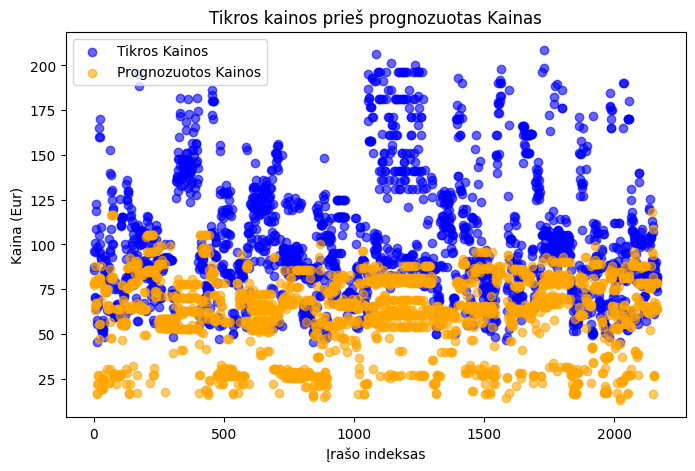

In [45]:
plt.figure(figsize=(8, 5))
plt.scatter(df2023_cleaned.index, df2023_cleaned["Kaina aukcione, Eur"], 
            color="blue", label="Tikros Kainos", alpha=0.6)
plt.scatter(df_predicted.index, df_predicted["Prognozuojama kaina aukcione"], 
            color="orange", label="Prognozuotos Kainos", alpha=0.6)
plt.xlabel("Įrašo indeksas")
plt.ylabel("Kaina (Eur)")
plt.title("Tikros kainos prieš prognozuotas Kainas")
plt.legend()
plt.show()

Atliekamas prognozavimas su įvedamais duomenimis ir įvestų duomenų išsaugojimas

In [47]:
pipeline = joblib.load(FILES_PATH / "best_xgboost_model1.pkl")

In [48]:
def input_to_file(input_df: pd.DataFrame, file_path: str = "inputs.csv") -> None:
    """
    Save the input DataFrame to a CSV file. If the file already exists, append the data; 
    otherwise, create a new file.

    Parameters:
    input_df (pd.DataFrame): The DataFrame containing the data to be saved.
    file_path (str): The path to the CSV file where the data will be saved. Default is 'inputs.csv'.

    Returns:
    None
    """
    my_file = Path(file_path)
    if my_file.is_file():
        input_df.to_csv(file_path, mode="a", index=False, header=False)
    else:
        input_df.to_csv(file_path, index=False)

In [53]:
single_input = {
    "Pardavėjas": "VĮ Radviliškio miškų urėdija",
    "Pirkėjas": 'ŽŪB " Šiaulėnų statyba"',
    "Sortimento pavadinimas": "Pjautinieji rąstai",
    "Rušies pavadinimas": "Eglė",
    "Kokybės klasė": "B",
    "Stambumo klasė": "St I 32-49",
    "Ilgio klase,m": "L2: 3.0-3.9"
}

input_df = pd.DataFrame([single_input])
input_to_file(input_df)
predictions = pipeline.predict(input_df)

print(f"Prognozuojama kaina yra: {predictions[0]:.2f} Eur/m3")

Prognozuojama kaina yra: 77.83 Eur/m3


Patikrinamas failas kur išsaugomi ivedami duomenys prognozavimui

In [54]:
pd.read_csv("inputs.csv")

,Pardavėjas,Pirkėjas,Sortimento pavadinimas,Rušies pavadinimas,Kokybės klasė,Stambumo klasė,"Ilgio klase,m"
0,Pardavėjas_1,Pirkėjas_1,Mediena,Azuolas,A,Vidutinė,6.5
1,VĮ Radviliškio miškų urėdija,"ŽŪB "" Šiaulėnų statyba""",Pjautinieji rąstai,Pušis,D,St I 32-49,L2: 3.0-3.9
2,VĮ Radviliškio miškų urėdija,"ŽŪB "" Šiaulėnų statyba""",Pjautinieji rąstai,Pušis,B,St I 32-49,L2: 3.0-3.9
3,VĮ Radviliškio miškų urėdija,"ŽŪB "" Šiaulėnų statyba""",Pjautinieji rąstai,Eglė,B,St I 32-49,L2: 3.0-3.9
4,VĮ Radviliškio miškų urėdija,"ŽŪB "" Šiaulėnų statyba""",Pjautinieji rąstai,Eglė,B,St I 32-49,L2: 3.0-3.9
5,VĮ Radviliškio miškų urėdija,"ŽŪB "" Šiaulėnų statyba""",Pjautinieji rąstai,Eglė,B,St I 32-49,L2: 3.0-3.9
6,VĮ Radviliškio miškų urėdija,"ŽŪB "" Šiaulėnų statyba""",Pjautinieji rąstai,Eglė,B,St I 32-49,L2: 3.0-3.9
7,VĮ Radviliškio miškų urėdija,"ŽŪB "" Šiaulėnų statyba""",Pjautinieji rąstai,Eglė,B,St I 32-49,L2: 3.0-3.9
8,VĮ Radviliškio miškų urėdija,"ŽŪB "" Šiaulėnų statyba""",Pjautinieji rąstai,Eglė,B,St I 32-49,L2: 3.0-3.9
9,VĮ Radviliškio miškų urėdija,"ŽŪB "" Šiaulėnų statyba""",Pjautinieji rąstai,Eglė,C,St I 32-49,L2: 3.0-3.9
